In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os, sys, glob
from PIL import Image
import io
import pickle
from collections import OrderedDict

In [355]:
dirstem = '/home/dbear/playtest0/'
# trials = sorted(glob.glob(dirstem), key=lambda t: int(t.split('_')[-1]))
# trials = {int(trial.split('_')[-1]): trial for trial in trials}
trials = dirstem
!ls `echo $dirstem`

0000.hdf5     0003_id.mp4   0006_img.mp4  0009_map.png	0013.hdf5
0000_id.mp4   0003_img.mp4  0006_map.png  0010.hdf5	0013_id.mp4
0000_img.mp4  0003_map.png  0007.hdf5	  0010_id.mp4	0013_img.mp4
0000_map.png  0004.hdf5     0007_id.mp4   0010_img.mp4	0013_map.png
0001.hdf5     0004_id.mp4   0007_img.mp4  0010_map.png	0014.hdf5
0001_id.mp4   0004_img.mp4  0007_map.png  0011.hdf5	0014_id.mp4
0001_img.mp4  0004_map.png  0008.hdf5	  0011_id.mp4	0014_img.mp4
0001_map.png  0005.hdf5     0008_id.mp4   0011_img.mp4	0014_map.png
0002.hdf5     0005_id.mp4   0008_img.mp4  0011_map.png	args.txt
0002_id.mp4   0005_img.mp4  0008_map.png  0012.hdf5	commandline_args.txt
0002_img.mp4  0005_map.png  0009.hdf5	  0012_id.mp4	tdw_commands.json
0002_map.png  0006.hdf5     0009_id.mp4   0012_img.mp4
0003.hdf5     0006_id.mp4   0009_img.mp4  0012_map.png


0014.hdf5
top keys ['frames', 'static']
num frames: 151
frame data keys ['camera_matrices', 'collisions', 'env_collisions', 'images', 'labels', 'objects']
image keys ['_depth', '_flow', '_id', '_img', '_normals']


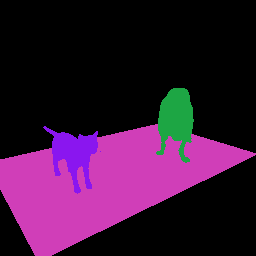

In [356]:
TDW_DIR = trials
TNUM = 14
FILE = "%04d.hdf5" % TNUM
print(FILE)
view_frame = 0
f = h5py.File(os.path.join(TDW_DIR, FILE))

# print the data structure
print("top keys", [k for k in f.keys()])
frames = f['frames']
n_frames = len([k for k in frames.keys()])
print("num frames: {}".format(n_frames))
view_frame = np.minimum(view_frame, n_frames - 1)
frame = frames["%04d" % (view_frame)]
print("frame data keys", [k for k in frame.keys()])
img = frame['images']
print("image keys", [k for k in img.keys()])
_img = Image.open(io.BytesIO(img["_id"][:]))
_img

<IPython.core.display.Javascript object>


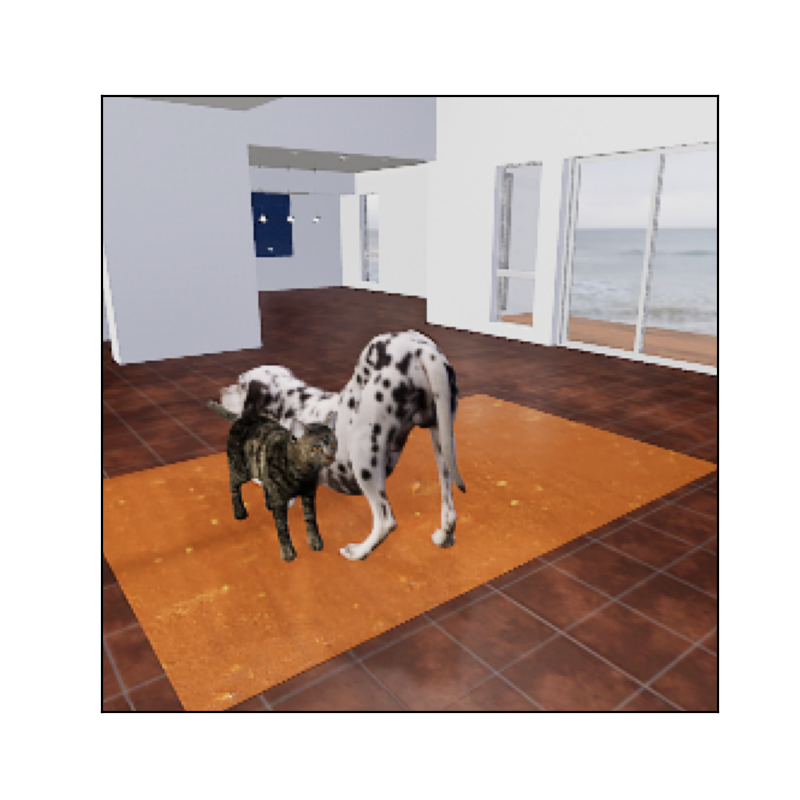

In [357]:
%matplotlib nbagg
SAVE = False

def get_frame(f, idx, imkey='_img', N=n_frames):
    fkeys = sorted([k for k in f['frames'].keys()])
    img = f['frames'][fkeys[idx % N]]['images']
    return np.array(Image.open(io.BytesIO(img[imkey][:]))), len(fkeys)

idx = 0

fig, axes = plt.subplots(figsize=(4,4))
fr0, n_frames = get_frame(f,idx)
im = plt.imshow(fr0, origin='upper')

def animate(*args):
    global idx
    
    fr, N = get_frame(f, idx, '_img')
    im.set_array(fr)
    idx += 1
    idx %= N
    
    return im,

def savegif(ani, directory=TDW_DIR, file=FILE):
    import os
    f = os.path.join(directory, file.split('.')[0]) + ".gif"
    writergif = animation.PillowWriter(fps=48)
    ani.save(f, writer=writergif)

ani = animation.FuncAnimation(fig, animate, interval=10, save_count=n_frames)
plt.xticks([])
plt.yticks([])
plt.show()

if SAVE:
    savegif(ani, TDW_DIR, FILE)

# Check Metadata

In [324]:
skeys = [k for k in f['static'].keys()]
print(skeys)

obj_ids = [oid for oid in f['static']['object_ids']]
print(obj_ids)

['bounciness', 'cloth_actors', 'color', 'container', 'distractors', 'dynamic_friction', 'fluid_actors', 'git_commit', 'initial_position', 'initial_rotation', 'mass', 'model_names', 'object_ids', 'object_segmentation_colors', 'occluders', 'randomize', 'room', 'scale', 'scale_x', 'scale_y', 'scale_z', 'seed', 'soft_actors', 'solid_actors', 'static_friction', 'stimulus_name', 'target_id', 'target_rotation', 'target_type', 'trial_num', 'trial_seed', 'zone_id']
[1, 3, 4, 5, 6]


In [197]:
key = 'zone_id'
meta = f['static'][key]
# meta
print(np.array(meta))

1


In [100]:
key = 'initial_position'
meta = f['static'][key]
# meta
print(np.array(meta))

[[ 1.6  0.1  0. ]
 [ 1.   0.1  0. ]
 [-1.   0.1  0. ]
 [ 1.   1.5  0. ]
 [ 0.   1.   0. ]]


In [289]:
key = 'object_segmentation_colors'
meta = f['static'][key]
# meta
print(np.array(meta))

[[ 79  10 252]
 [168 158  92]
 [ 62 167 230]
 [171 211 174]
 [234  21 249]]


<IPython.core.display.Javascript object>


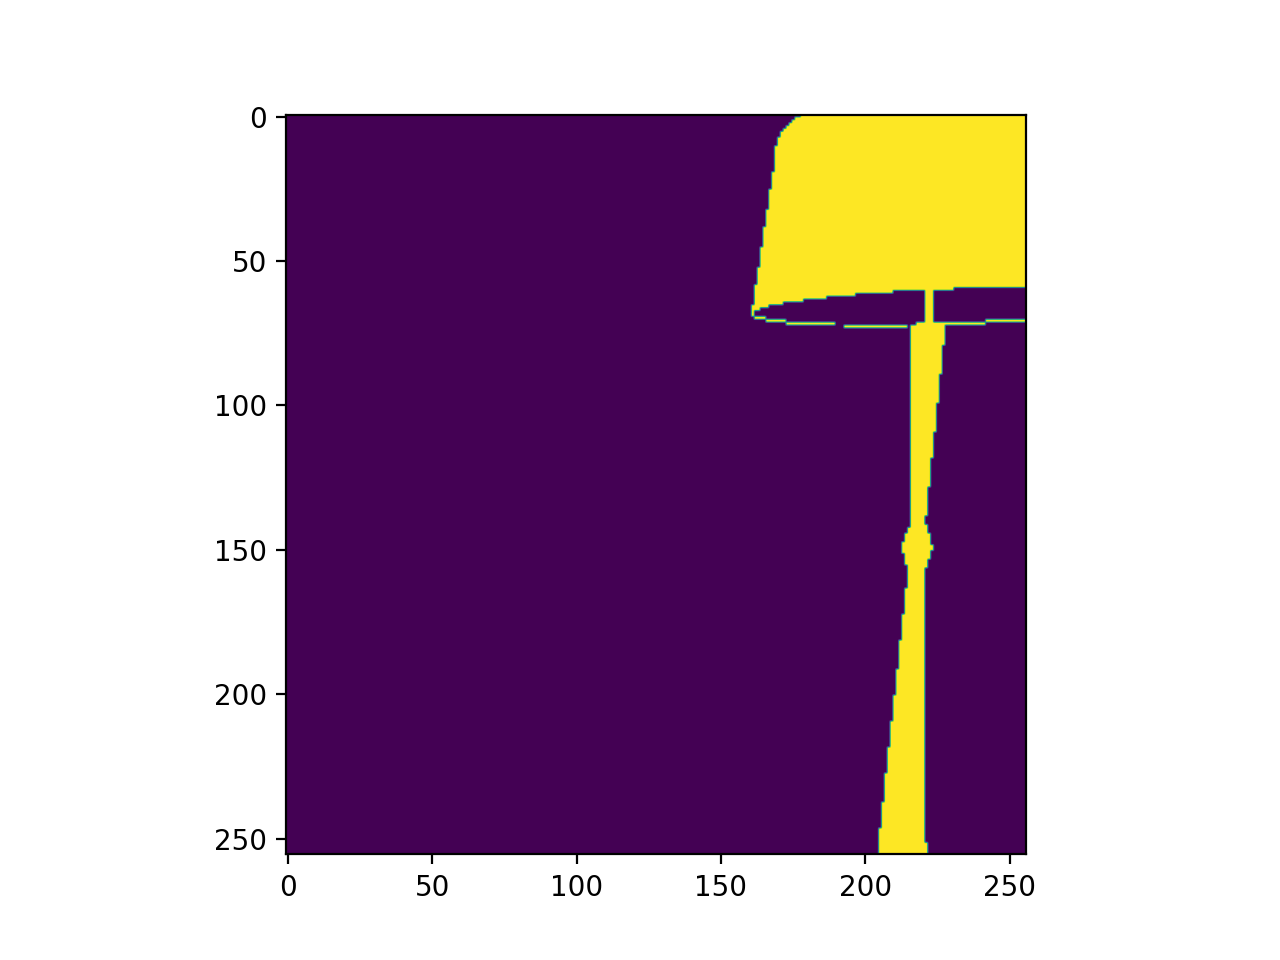

In [294]:
mask = np.array(_img) == meta[3]
plt.imshow(mask.max(axis=-1))

In [331]:
np.array(f['frames']['0000']['labels']['minimum_distance_target_to_zone'])

array(1.2293937, dtype=float32)

# Frame Data

In [325]:
fs = [k for k in f['frames'].keys()]
print("dynamic keys")
print([k for k in f['frames'][fs[0]].keys()])
print("collision keys")
print([k for k in f['frames'][fs[0]]['collisions'].keys()])

def get_collisions(hf, idx, env_collisions=False):
    fkeys = [k for k in hf['frames'].keys()]
    return hf['frames'][fkeys[idx]]['collisions' if not env_collisions else 'env_collisions']

def find_collisions_frames(hf, cdata='contacts', env_collisions=False):
    n_frames = len([k for k in hf['frames'].keys()])
    collisions = []
    for n in range(n_frames):
        contacts = get_collisions(hf, n, env_collisions)[cdata]
        collisions.append(bool(len(contacts)))
    return np.where(collisions)[0]

def did_fall(hf, idx=-1):
    fkeys = [k for k in hf['frames'].keys()]
    n_frames = len(fkeys)
    if n_frames > 5 and (idx % n_frames > 5):
        return np.array(hf['frames'][fkeys[idx]]["did_fall"])
    else:
        return None

dynamic keys
['camera_matrices', 'collisions', 'env_collisions', 'images', 'labels', 'objects', 'particles', 'velocities']
collision keys
['contacts', 'object_ids', 'relative_velocities', 'states']


In [153]:
cframes = find_collisions_frames(f, 'object_ids', False)
for cf in cframes:
    print("frame", cf, "colliding ids", np.array(get_collisions(f, cf, False)['object_ids']))

frame 97 colliding ids [[3 5]]
frame 98 colliding ids [[3 5]]
frame 99 colliding ids [[3 5]]
frame 100 colliding ids [[3 5]]
frame 101 colliding ids [[3 5]]
frame 102 colliding ids [[3 5]]
frame 103 colliding ids [[3 5]]
frame 104 colliding ids [[3 5]]


In [208]:
np.array(f['frames']['0100']['particles']['6'][0])

array([ 1.6604432e-01,  3.9693385e-02, -9.9761361e-01,  8.4500000e+03],
      dtype=float32)

In [403]:
np.array(f['frames'][fs[0]]['objects']['rotations'])

array([[ 4.76518913e-08, -2.22390552e-12,  4.22937588e-11,
         1.00000000e+00],
       [ 3.01082501e-08,  1.30342159e-09, -2.09958273e-09,
         1.00000000e+00],
       [ 1.74940826e-04, -5.40700021e-05, -4.44623567e-02,
         9.99011159e-01],
       [ 2.41519320e-08,  1.47538409e-01, -5.35223155e-09,
         9.89056349e-01],
       [ 1.10243485e-08,  1.20318994e-01, -1.39708325e-08,
         9.92735326e-01],
       [ 2.63911453e-08,  3.43538642e-01,  1.91433536e-09,
         9.39138532e-01]], dtype=float32)

In [429]:
idx = 1
fs = list(f['frames'].keys())
labels = f['frames'][fs[idx]]['labels']
print("frame num %d of %d" % (idx % len(fs) + 1, len(fs)))
for k in list(labels.keys()):
    print(k, np.array(labels[k]))
    
tzc = [np.array(f['frames'][fs[i]]['labels']['has_zone']) for i in range(len(fs))]
print(np.where(tzc))

frame num 2 of 151
has_target False
has_zone True
trial_complete False
trial_end False
trial_timeout False
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150]),)


In [93]:
print(list(get_collisions(f, 100, False).keys()))
np.array(get_collisions(f, 100, False)['object_ids'])

['contacts', 'object_ids', 'relative_velocities', 'states']


array([[3, 5]])

In [262]:
(f['frames']['0144']['particles']['6'][0,0:3],
f['frames']['0144']['particles']['3'][-1,0:3])

(array([-0.00947087,  0.02500036, -0.98643285], dtype=float32),
 array([-0.45046315,  1.249558  ,  0.22749856], dtype=float32))

In [301]:
def are_particles_touching(f, obj1, obj2, frame=0, thresh=0.025):
    frames = list(f['frames'].keys())
    p1 = np.array(f['frames'][frames[frame]]['particles'][str(obj1)])[:,0:3]
    p2 = np.array(f['frames'][frames[frame]]['particles'][str(obj2)])[:,0:3]
    print(p1[:,1].max(), p2[:,1].max())
    
    dists = np.sqrt(np.square(p1[:,None] - p2[None,:]).sum(-1))
    print(dists.shape)
    print(dists.min())
    touching = (dists < thresh).max()
    print(touching)
    
    return touching


are_particles_touching(f, 3, 6, frame=0, thresh=0.15)

1.249557 1.4993477
(2520, 4225)
0.24981229
False


False

In [296]:
touch = [are_particles_touching(f, 4, 6, frame=i, thresh=0.2) for i in range(50)]

0.7095624 1.4993477
(1680, 4225)
0.7899307
False
0.7095624 1.4977244
(1680, 4225)
0.7883078
False
0.70956236 1.4951398
(1680, 4225)
0.78572375
False
0.7095624 1.4916036
(1680, 4225)
0.7821881
False
0.70956254 1.487125
(1680, 4225)
0.77771026
False
0.7095628 1.481713
(1680, 4225)
0.77229905
False
0.70956254 1.4753773
(1680, 4225)
0.7659647
False
0.7095618 1.4681271
(1680, 4225)
0.7587166
False
0.7095603 1.4599714
(1680, 4225)
0.750564
False
0.70955896 1.4509192
(1680, 4225)
0.74151486
False
0.70955825 1.4409795
(1680, 4225)
0.7315779
False
0.7095579 1.4301611
(1680, 4225)
0.7207621
False
0.7095581 1.4184728
(1680, 4225)
0.70907605
False
0.709558 1.4059232
(1680, 4225)
0.69652945
False
0.709558 1.3925211
(1680, 4225)
0.68313044
False
0.7095579 1.3782749
(1680, 4225)
0.6688878
False
0.70955753 1.3737671
(1680, 4225)
0.65380996
False
0.7095582 1.3749071
(1680, 4225)
0.63790405
False
0.7095592 1.37477
(1680, 4225)
0.621179
False
0.7095605 1.3740952
(1680, 4225)
0.60364383
False
0.7095623 1.

# Check Labels

In [358]:
%reload_ext autoreload
%autoreload 2

In [446]:
np.mean([True, False, False])

0.3333333333333333

In [335]:
f['frames']['0000']['camera_matrices']['camera_matrix'].shape

(16,)